<img src="logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**

<hr />

# Planar potential flows past stationary bodies

In this notebook, we'll take a look at how we can use distributions of singularities to generate potential flows past stationary obstacles.

### Set up the module

In [1]:
using MAE150A

In [2]:
using LinearAlgebra: diagm

In [3]:
pyplot()
initialize_environment()

This notebook will work with distributions of singularities. It will use some complex variables behind the scenes, and we need the help of a function for computing the dot product between two vectors expressed in complex form:

In [4]:
"""
    dotproduct(a,b)

Compute the dot product between `a` and `b`, each given as complex
forms of two-dimensional vectors.
"""
dotproduct(a::Number, b::Number) = real(conj(a)*b)

dotproduct

## Distributions of singularities

Suppose we want to model a solid surface in a potential flow.
The only role of that surface is to prevent fluid from going through it.
We can accomplish the same thing by replacing the surface with a **distribution of singularities**. We place a large number of singularities (e.g., source, vortices, or doublets) on the surface of the body, and solve for their strengths such that the no-flow-through condition is enforced.

Mathematically, we would use an infinite number of singularities, each with vanishingly-small strength. But in practice, we can do very well by just using a large number, and then enforcing the no-flow-through condition at these points.

This forms a linear algebra problem: **find the strengths of $N$ singularities to enforce the no-flow-through condition at $N$ points.**

First, let us set up a free stream

In [5]:
U∞ = 1.0 + 0im
fs = Freestreams.Freestream(U∞)

PotentialFlow.Freestreams.Freestream(1.0 + 0.0im)

### Flow past a triangle

Let's start by considering flow past a equilateral triangle.
We will discretize this triangle into small segments, each with length $\Delta s$. It is a little complicated to construct, but don't get stuck in the details here. Just look at the result below.

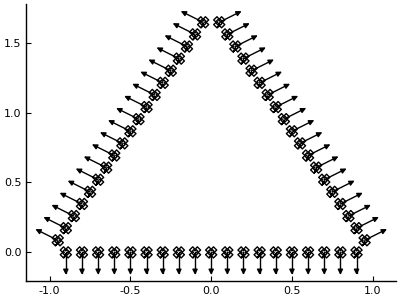

In [6]:
# parameterization along each side
Δs = 0.1
s = -(1 - Δs):Δs:(1 - Δs)

# Create sources of strength = 1 on each side
bottom = Source.Point.(s, 1.0)
right  = Source.Point.((s .+ 1).*exp(im*2π/3) .+ 1, 1.0)
left   = Source.Point.((s .+ 1)*exp(-im*2π/3) .+ im*√3, 1.0)

# Set up the list of sources.
sources = vcat(bottom, right, left)

# The targets are the locations at which we want to evaluate the velocity. These coincide with
# the locations of the sources
targets = Elements.position.(sources)

# The list of normal vectors at each source location
n̂ = vcat(
    fill(-1.0im, length(bottom)),
    fill(exp(im*π/6), length(right)),
    fill(exp(im*5π/6), length(left)))

# Each source represents a segment of the side. This is the list of segment lengths
Δs = fill(Δs, length(n̂));

# Let's plot the sources and normals just to make sure it looks like what we want:
plot(sources)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)
plot!(sources, markersize = 8)

The cross marks correspond to the center of each source, and the arrows correspond to the normal vectors along the surface.

So the velocity at any point in the fluid is equal to the freestream plus the velocity induced by each of the $N$ point sources:

$$
\mathbf{u}(\mathbf{x}) = \mathbf{U}_\infty + \sum_{n = 1}^N \mathbf{u}_n(\mathbf{x})
$$

If we want enforce the no-flow-through condition at the point sources, then we must have

$$
\sum_{n = 1}^N \mathbf{n}_i \cdot \mathbf{u}_n(\mathbf{x}_i) = - \mathbf{n}_i \cdot \mathbf{U}_\infty \qquad \text{for } i = 1, 2, \cdots, N.
$$

As long as the we are not evaluating the velocity that a segment induces on itself, we will treat the segment as a point source:

$$
    \mathbf{u}_n(\mathbf{x})
  = \frac{Q_n }{2\pi}
    \frac{\mathbf{x} - \mathbf{x}_n}
         {|\mathbf{x} - \mathbf{x}_n|^2} \qquad \text{when } \mathbf{x} \neq \mathbf{x}_n
$$

But how **would** we evaluate $\mathbf{u}_n(\mathbf{x}_n)$?  We probably won't go over it in class, so you'll just have to believe ([or not](#Or-Not)) that it is:

$$
\mathbf{n}_n \cdot \mathbf{u}_n(\mathbf{x}_n) = \frac{Q_n}{2\Delta s}
$$

<a id="back"></a>

So the no-flow-through condition above can be written in matrix form:

$$
\underbrace{
\begin{bmatrix}
\frac{1}{2\Delta s} & \mathbf{n}_1 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_1 - \mathbf{x}_2}{|\mathbf{x}_1 - \mathbf{x}_2|^2}
& \cdots & \mathbf{n}_1 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_1 - \mathbf{x}_N}{|\mathbf{x}_1 - \mathbf{x}_N|^2}
\\
\mathbf{n}_2 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_2 - \mathbf{x}_1}{|\mathbf{x}_2 - \mathbf{x}_1|^2} & \frac{1}{2\Delta s}
& & \vdots
\\
\vdots & & \ddots & \vdots \\
\mathbf{n}_N \cdot \frac{1}{2\pi}\frac{\mathbf{x}_N - \mathbf{x}_1}{|\mathbf{x}_N - \mathbf{x}_1|^2} &
\cdots & \cdots &
\frac{1}{2\Delta s}
\end{bmatrix}}_{A}
\begin{bmatrix}
Q_1 \\
Q_2 \\
\vdots \\
\vdots \\
Q_n
\end{bmatrix} =
\underbrace{ -
\begin{bmatrix}
\mathbf{n}_1 \cdot \mathbf{U}_\infty \\
\mathbf{n}_2 \cdot \mathbf{U}_\infty \\
\vdots \\
\vdots \\
\mathbf{n}_N \cdot \mathbf{U}_\infty \\
\end{bmatrix}}_{b},
$$

which we can solve to find the strengths of the point sources.
In code, this will look something like:

In [7]:
# The right-hand side
b = -dotproduct.(n̂, U∞)

# Form the matrix elements:
A = [dotproduct(n, induce_velocity(target, source, 0)) for (n, target) in zip(n̂, targets), source in sources]
A .+= 0.5*diagm(0 => 1 ./ Δs)

# And solve it...
Q = A \ b;

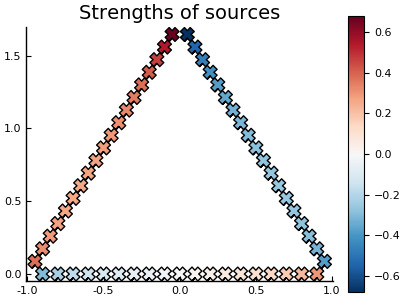

In [8]:
sources = Source.Point.(targets, Q)

plot(sources, color = :RdBu_r, colorbar = :right, markersize = 10, title = "Strengths of sources")

In the figure above, red x's correspond to sources while blue x's correspond to sinks.
Now, we will look at the streamlines for this flow.

#### Streamlines
Now let's plot the streamlines. Instead of using the streamfunction, as we have done before, we will compute streamlines from the trajectories of tracer particles. This avoids the challenges of dealing with the branch cut in the streamfunction for a source. We set up an vector of complex points where we wish to start the trajectories:

In [9]:
# a bunch of points along the left side of the obstacle
zstart = collect(-3.0 .+ range(-3,3,length=30)*im)

30-element Array{Complex{Float64},1}:
 -3.0 - 3.0im               
 -3.0 - 2.793103448275862im 
 -3.0 - 2.586206896551724im 
 -3.0 - 2.3793103448275863im
 -3.0 - 2.1724137931034484im
 -3.0 - 1.9655172413793105im
 -3.0 - 1.7586206896551724im
 -3.0 - 1.5517241379310345im
 -3.0 - 1.3448275862068966im
 -3.0 - 1.1379310344827587im
 -3.0 - 0.9310344827586208im
 -3.0 - 0.7241379310344828im
 -3.0 - 0.5172413793103449im
      ⋮                     
 -3.0 + 0.7241379310344828im
 -3.0 + 0.9310344827586207im
 -3.0 + 1.1379310344827587im
 -3.0 + 1.3448275862068966im
 -3.0 + 1.5517241379310345im
 -3.0 + 1.7586206896551724im
 -3.0 + 1.9655172413793103im
 -3.0 + 2.1724137931034484im
 -3.0 + 2.3793103448275863im
 -3.0 + 2.586206896551724im 
 -3.0 + 2.793103448275862im 
 -3.0 + 3.0im               

In [10]:
Tmax = 20
Δt = 0.01
tx, ty = compute_trajectories((fs,sources),zstart,Tmax,Δt);

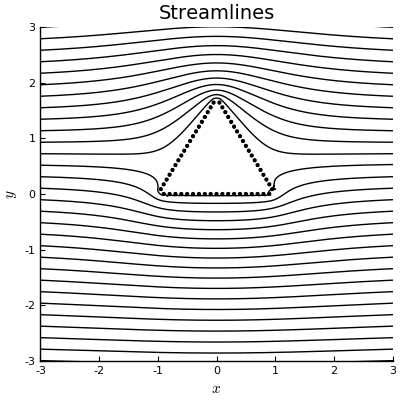

In [11]:
plt = plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400), title = "Streamlines")
plot!(plt, sources, markersize = 2, color = :RdBu_r)

#### Pressure distribution
Let's calculate the pressure distribution the surface of the object. We will need the fluid velocity on the surface for this. To calculate this, we simply evaluate it at all of the source locations. However, the source's effect on itself needs to be added in explicitly. Let's create a function to do that work for us.

In [12]:
function surface_velocity(targets,sources,other_elements,n̂,Δs)
    us = induce_velocity(targets, (other_elements,sources), 0)
    for (i,(ni,Δsi,source)) in enumerate(zip(n̂,Δs,sources))
        us[i] -= 0.5*im*source.S*ni/Δsi
    end
    return us
end

surface_velocity (generic function with 1 method)

Now, the pressure can be obtained by applying the Bernoulli equation between two points, one at a large distance away where we only have a uniform flow. The flow is steady and gravity is ignored here, so this is just

$$ p = p_\infty + \frac{1}{2}\rho U_\infty^2 - \frac{1}{2}\rho |\mathbf{u}|^2 $$ 

The **pressure coefficient** is defined as the difference of the pressure from the ambient pressure, normalized by the dynamic pressure in the uniform flow:

$$ C_p = \dfrac{p - p_\infty}{\frac{1}{2} \rho U_\infty^2} $$

Putting these two things together, the pressure coefficient is

$$ C_p = 1 - |\mathbf{u}|^2/U_\infty^2 $$

Remember that we are only interested here in the pressure at points on the surface, so $\mathbf{u}$ is the surface velocity. Let's compute the pressure coefficient here. We will plot it by coloring the source points with the local value of $C_p$.

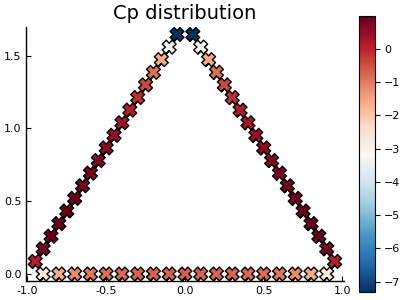

In [13]:
us = surface_velocity(targets,sources,fs,n̂,Δs)
Cp = 1 .- dotproduct.(us,us)/dotproduct(U∞,U∞)
plot(sources, marker_z = Cp, color = :RdBu_r, colorbar = :right, markersize = 10, title = "Cp distribution")

Before moving on, we'll wrap all of our steps into a function so we don't have to keep repeating ourselves. But we will add a little bit more functionality, too. There is no reason we need to limit ourselves to just a uniform flow outside of our body. Maybe we want to include, say, some vortices outside the body, too. They can all be included in the superposition:

$$
\mathbf{u}(\mathbf{x}) = \mathbf{u}_{\mathrm{other}} + \sum_{n = 1}^N \mathbf{u}_n(\mathbf{x})
$$

where $\mathbf{u}_{\mathrm{other}}$ is the sum of the velocity from *other elements*, like uniform flow and vortices outside the body shape. If we want enforce the no-flow-through condition at the point sources, then we just put all the elements with known values on the right side: 

$$
\sum_{n = 1}^N \mathbf{n}_i \cdot \mathbf{u}_n(\mathbf{x}_i) = - \mathbf{n}_i \cdot \mathbf{u}_{\mathrm{other}}(\mathbf{x}_i) \qquad \text{for } i = 1, 2, \cdots, N.
$$

In the function defined below, we can provide a list of these other elements in the argument `other_elements`. Examples below will show how it is used

In [14]:
# This function has default values for the starting points of the tracer particles and the integration time
# and time step size for the trajectory integration. You can override any of these, as examples below will show.

function simulate_flow(unit_sources, Δs, n̂, other_elements; tracer_start = collect(-3.0 .+ range(-3,3,length=31)*im), Tmax = 20.0, Δt = 0.01)
    
    # locations at which we enforce no flow through
    targets = Elements.position.(unit_sources)

    # velocity induced by other elements at the target points
    other_vel = induce_velocity(targets,other_elements,0)
    
    b = -dotproduct.(n̂, other_vel)
    
    A = [dotproduct(n, induce_velocity(target, source, 0)) for (n, target) in zip(n̂, targets), source in unit_sources]
    A .+= 0.5*diagm(0 => 1 ./ Δs)

    Q = A \ b
        
    sources = Source.Point.(targets, Q)

    # compute other stuff, like surface velocity, pressure, and tracer trajectories
    
    us = surface_velocity(targets, sources, other_elements, n̂, Δs)

    Cp = 1 .- dotproduct.(us,us) #/dotproduct(U∞,U∞)
        
    tx, ty = compute_trajectories((other_elements,sources),tracer_start,Tmax,Δt)
    
    
    sources, us, Cp, tx, ty
end

simulate_flow (generic function with 1 method)

### Flow Past a Cylinder
We will now look at flows past a circular cylinder. This is a useful problem because we already know what the flow should be, so we can check that everything works.

Since we will use this a lot, let's make a function that constructs a circle of points. It also supplies the unit normal vectors and the lengths of the segments:

In [15]:
function circle(center::Number,radius::Float64,n::Int)
    θ = range(0, 2π, length=n+1)[1:end-1]
    z = center .+ radius*exp.(im.*θ)
    n̂ = radius*exp.(im.*θ)
    Δs = radius*fill(step(θ), length(θ))
    return z, n̂, Δs
end

circle (generic function with 1 method)

As before, we first construct the surface of the body with point sources. A circle of radius 1 centered at the origin.

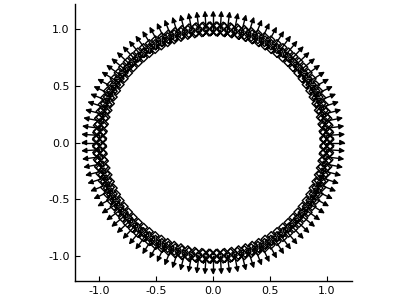

In [16]:
center = 0.0+0im
r = 1.0
npts = 100
z, n̂, Δs = circle(center,r,npts)

# sources of unit strength
sources = Source.Point.(z, 1.0);
targets = Elements.position.(sources)

plot(sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)
plot!(sources, markersize = 10)

Now with a freestream from left to right, we have:

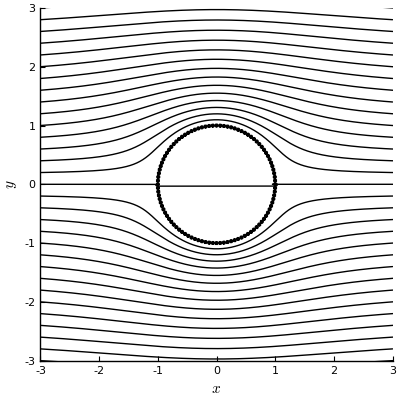

In [17]:
U∞ = 1.0+0im
other_elements = Freestreams.Freestream(U∞)
actual_sources, us, Cp, tx, ty = simulate_flow(sources, Δs, n̂, other_elements)
plt = plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400))
plot!(plt, sources, markersize = 2, color = :RdBu_r)

Let's compute the pressure distribution on the shape. 

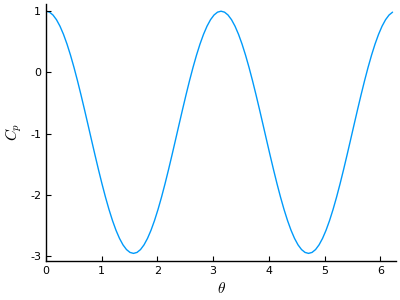

In [18]:
θ = range(0, 2π, length=length(Cp)+1)[1:end-1]
plot(θ,Cp,xlim=(0,2π),xlabel=L"\theta",ylabel=L"C_p")

This agrees with our expected result, $C_p(\theta) = 1 - 4\sin^2\theta$.

What is the total force on the body? That comes by integrating the pressure times the local normal:

$$ \mathbf{F} = -\int_{S} p\mathbf{n}\mathrm{d}A $$

This integral (non-dimensionalized by the reference dynamic pressure) is approximately given by the **sum** over the surface pressure coefficients times normals times segment lengths: 

In [19]:
F = -sum(Cp.*n̂.*Δs)

-1.1934897514720433e-15 + 1.429412144204889e-15im

The force has very tiny values for both $F_x$ (the real part) and $F_y$ (the imaginary part). This is **d'Alembert's paradox**. (But is this *always* the case for a potential flow past a closed body?)

### Flow past an airfoil
In this example, we will compute the flow past an airfoil. NACA airfoils are a family of airfoil shapes in which the camber and thickness can be independently chosen. For example, NACA 4212 indicates an airfoil with 4% camber (the "4"), with maximum camber at location 20% of the chord length (the "2"), and thickness 12% of the chord (the "12"). Symmetric members of the family have the numbers 00xx.

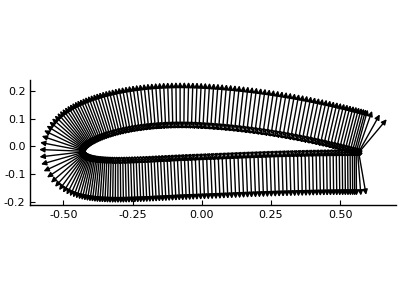

In [20]:
targets = naca4(0.04,0.4,0.12,np=100)

# get the lengths and normals of each point
dt = 0.5*[diff(targets);0]
dz = dt + circshift(dt,1) 
Δs = abs.(dz)
n̂ = -im*dz./Δs;

sources = Source.Point.(targets, 1.0)

plot(sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)

Now we will compute the flow at 5 degrees angle of attack:

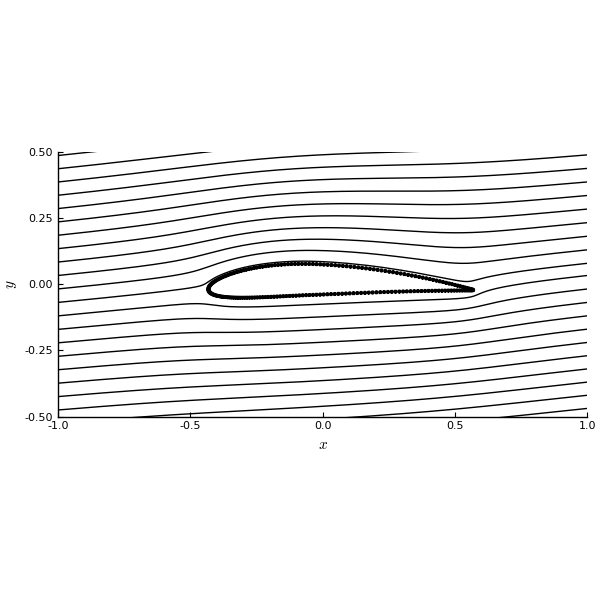

In [29]:
α = 5*π/180
U∞ = 1.0*exp(im*α)
other_elements = Freestreams.Freestream(U∞)
actual_sources, us0, Cp, tx, ty = simulate_flow(sources, Δs, n̂, other_elements, tracer_start = collect(-3 .+ im*range(-1,0.5,length=31)));
plt = plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-1, 1), ylim = (-0.5, 0.5), size = (600, 600), ratio=1)
plot!(plt, sources, markersize = 2, color = :RdBu_r)

Let's look at the surface velocity on this airfoil. The plot below "unwraps" the x component of the surface velocity, plotting it from the top of the trailing edge, then counterclockwise around the airfoil to the bottom of the trailing edge. Note the big jump at the trailing edge (the first point and the last point in this plot).

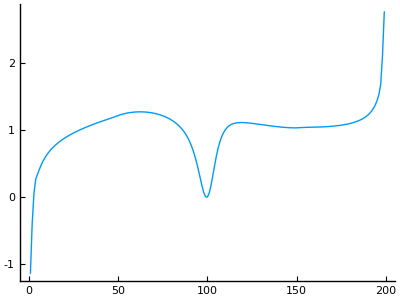

In [30]:
plot(real.(us0))

You might notice that the flow does not come smoothly off the trailing edge, evident in the big jump in velocity there. In fact, we need to supply circulation about the airfoil in just the right measure to make this flow come smoothly off. This condition of "smooth" flow at the trailing edge is called the **Kutta condition**. This circulation is called the **bound circulation** of the airfoil.

We will put a point vortex at the origin and determine the strength of this vortex so that the condition is enforced. There are various ways to check the Kutta condition. An easy way is to look at the jump in surface velocity at the points on either side of the trailing edge. **When the difference between these values is minimum, the Kutta condition is enforced.**

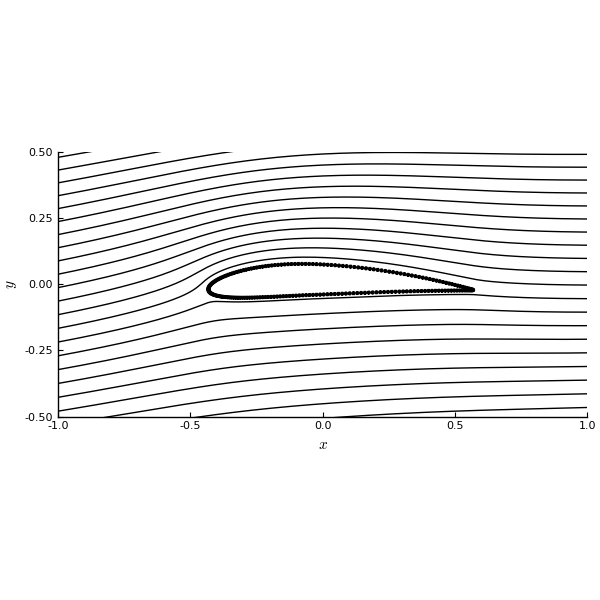

In [31]:
U∞ = 1.0*exp(im*5*π/180)

# strength 
Γ = -0.583

other_elements = (Freestreams.Freestream(U∞),Vortex.Point(0+0im,Γ))
actual_sources, us, Cp, tx, ty = simulate_flow(sources, Δs, n̂, other_elements, tracer_start = collect(-3 .+ im*range(-1,0.5,length=31)));
plt = plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-1, 1), ylim = (-0.5, 0.5), size = (600, 600))
plot!(plt, sources, markersize = 2, color = :RdBu_r,ratio=1)

Here is the jump in velocity at the trailing edge. We want this value to be as small as possible.

In [33]:
abs(us[1]-us[end])

0.5944158886060774

Now let's plot the surface velocity again, comparing it with the original. There is no more jump. (There is a small bump near the center, but this not really physical and comes from using only a finite number of sources.)

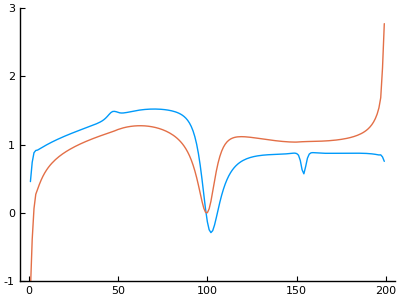

In [32]:
plot(real.(us),ylim=(-1,3))
plot!(real.(us0),ylim=(-1,3))

The force

In [27]:
F = -sum(Cp.*n̂.*Δs)

-0.09858321436607598 + 1.1676191405946417im

There is both an $x$ and a $y$ component. The circulation only generates force perpendicular to the free stream. But the free stream is at an angle, so the force itself is also at a slight angle.

### Flow Past a Happy Face

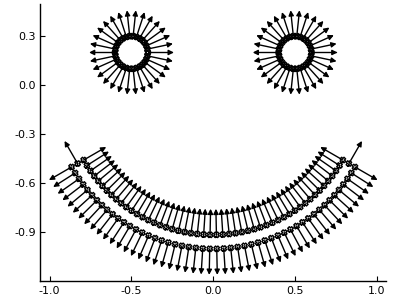

In [28]:
ns = 50
θ = range(π/6, 5π/6, length=ns)
Δs = step(θ)
targets = exp.(-im*θ)
n̂ = targets;
targets = vcat(targets, reverse((1 - 2Δs)*targets, 1))
n̂ = vcat(n̂, -reverse(n̂, 1))
#n̂[1] *= exp(im*π/4)
#n̂[ns] *= exp(-im*π/4)

dt = 0.5*[diff(targets);0]
dz = dt + circshift(dt,1) 
Δs = abs.(dz)

# add points on the ends of the smile
push!(targets,0.5*(targets[1]+targets[2ns]))
push!(Δs,2step(θ))
push!(n̂,n̂[1]*im)

push!(targets,0.5*(targets[ns]+targets[ns+1]))
push!(Δs,2step(θ))
push!(n̂,-n̂[ns]*im)    
        
θᵢ = range(0, 2π, length=31)[1:end-1]
left_eye = 0.1exp.(im*θᵢ) .- 0.5 .+ 0.2im
right_eye = 0.1exp.(im*θᵢ) .+ 0.5 .+ 0.2im;

append!(targets, left_eye)
append!(targets, right_eye)
append!(Δs, fill(0.5π/length(θᵢ), 2length(θᵢ)))
append!(n̂, exp.(im*θᵢ))
append!(n̂, exp.(im*θᵢ))

sources = Source.Point.(targets, 1.0);
plot(sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)

With $U_\infty$ going downward:

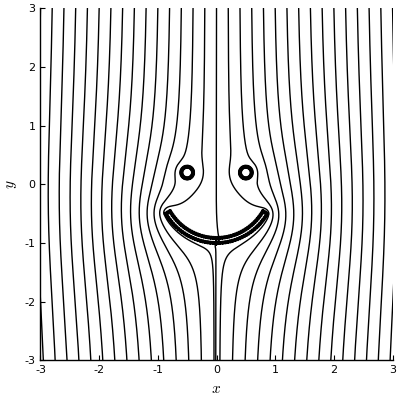

In [29]:
U∞ = 0.0-im
other_elements = Freestreams.Freestream(U∞)
actual_sources, us, Cp, tx, ty = simulate_flow(sources, Δs, n̂, other_elements, tracer_start = collect(range(-3,3,length=31) .+ 3im),Δt = 0.0025)
plt = plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400))
plot!(plt, sources, markersize = 2, color = :RdBu_r)

With $U_\infty$ going from left to right:

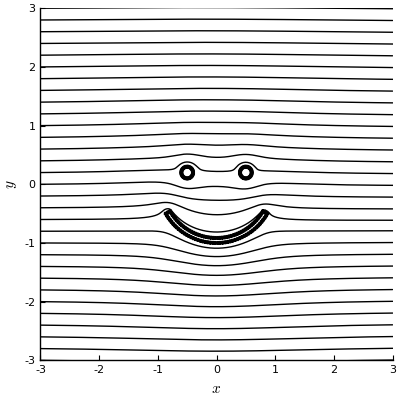

In [30]:
U∞ = 1.0+0im
other_elements = Freestreams.Freestream(U∞)
actual_sources, us, Cp, tx, ty = simulate_flow(sources, Δs, n̂, other_elements)
plt = plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400))
plot!(plt, sources, markersize = 2, color = :RdBu_r)

## Appendix

### Or Not

We'll have to discuss source sheets for a little bit here to find out the velocity that the sheet induces on itself.
To keep it simple, we will use a straight sheet segment with length $\Delta s$ centered around the origin.
The equation describing this sheet segment is given by:

$$
\mathbf{u}_s(\mathbf{x}) = \frac{1}{2\pi}
\int_{-\Delta s/2}^{\Delta s/2}
\sigma(l) \frac{\mathbf{x} - \mathbf{x}_s(l)}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l,
$$

where $\sigma$ is the local strength of the sheet.
This is not all that different from the point sources, except when you approach the sheet.

We first assume that $\Delta s$ is small enough that $\sigma$ is essentially constant in the interval.
Then, if we parametrize the target point as

$$
\mathbf{x} = r\cos\theta\,\mathbf{i} + r\sin\theta\,\mathbf{j},
$$

we obtain

$$
\begin{align*}
\mathbf{u}_s(\mathbf{x})
& = \frac{\sigma(0)}{2\pi}
\left[ \mathbf{i}
\int_{-\Delta s/2}^{\Delta s/2}
\frac{(r\cos\theta - l)}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l + \mathbf{j}
\int_{-\Delta s/2}^{\Delta s/2}
\frac{r\cos\theta}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l
\right] \\
& =-\frac{\sigma(0)}{2\pi}
\left( \frac{\mathbf{i}}{2}
\log\left[ (r\cos\theta - l)^2 + (r\sin\theta)^2
\right]_{-\Delta s/2}^{\Delta s/2} + \left. \mathbf{j}
\tan^{-1 }\left(\frac{r\cos\theta - l}
{r\sin\theta}
\right)
\right|_{-\Delta s/2}^{\Delta s/2}
\right)
\end{align*}
$$

As $\mathbf{x}$ approaches the origin, $r$ goes to zero

$$
\lim_{r \rightarrow 0}
\mathbf{u}_s(\mathbf{x}) = \mathrm{sign}(\theta)\frac{\sigma(0)}{2}.
$$

Since we are using point sources to model a segment of a source sheet, its strength $S$ is distributed along the segment, i.e.

$$
S = \int_{-\Delta s/2}^{\Delta s/2} \sigma(l) \mathrm{d}l.
$$

For a short sheet segment, we assume that $\sigma$ is essentially constant along the segment, so we have $\sigma \approx \frac{S}{\Delta s}$, which finally gives us

\begin{equation}
\lim_{r \rightarrow 0} \mathbf{u}_s(\mathbf{x}) = \frac{S}{2\Delta s}
\end{equation}

You can go [back](#back) now.